# Keras implementation of the Yolo Tiny V1 model

The original implementation was written in a framework called darknet. The author's website provides links to the paper, software and weights: [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolov1/).

The Yolo v1 implementation went through multiple revisions (v1, v1.1) and it looks like they weren't always documented. This situation made it really hard to find the original network definition and matching weights.

The fact that the definitions and weights provided on the author's website and github don't match up made the implementation more challening than neccessary but thanks to a bunch of awesome people on Github I was able to find everything i needed to get going:

* Darknet config: https://github.com/thtrieu/darkflow/blob/master/cfg/v1/yolo-tiny.cfg
* Weights: https://github.com/xslittlegrass/CarND-Vehicle-Detection

__Why Yolo v1 and not v2?__

I wanted to keep the layers simple to make porting to other frameworks/platforms (Android, iOS) as easy as possible.

### Define the model

In [1]:
%reset
%matplotlib inline

from keras import models
from keras import layers
from keras.layers.advanced_activations import LeakyReLU

def create_yolov1_tiny_model(shape):
    model = models.Sequential()

    model.add(layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', input_shape=shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))

    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))

    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))

    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))

    model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))

    model.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.Dense(4096))
    model.add(LeakyReLU(0.1))
    model.add(layers.Dense(1470))
    
    return model

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Using TensorFlow backend.


## Darknet weight loading

Download https://drive.google.com/file/d/0B1tW_VtY7onibmdQWE1zVERxcjQ/view and save as `yolo-tiny.weights`.

_Weights and code via https://github.com/xslittlegrass/CarND-Vehicle-Detection_

I had to adapt the weight loading code to support Keras 2.x conv layers.

In [2]:
# from https://github.com/xslittlegrass/CarND-Vehicle-Detection/blob/master/utils/utils.py
import numpy as np

def load_weights(model,yolo_weight_file):
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
 
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            
            # had to add this to accomodate the new weights structure for conv layers since Keras 2.x
            if(len(kshape) == 4):
                kshape = (kshape[3], kshape[2], kshape[0], kshape[1])
            
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            
            # had to add this to accomodate the new weights structure for conv layers since Keras 2.x
            if(len(kshape) == 4):
                ker = np.transpose(ker,(2, 3, 1, 0))
            
            layer.set_weights([ker,bia])

## Instantiate the model and  load darknet weights

We use the theano data format and dim ordering since the original darknet weights are in the same format. We'll create tensorflow compatible weights later on.

In [3]:
import keras

keras.backend.set_image_data_format('channels_first')
keras.backend.set_image_dim_ordering('th')

shape = (3,448,448) # channel_first
model = create_yolov1_tiny_model(shape)
        
load_weights(model, 'yolo-tiny.weights') # darknet weights

## Save keras weights

The weights are currenlty in theano format. We'll have to convert them later to support the tensorflow data format and dim ordering.

In [4]:
model.save_weights('yolo-tiny_th.weights', overwrite=True)  # keras theano weights

## Make a Testrun

Load a test image, normalize it and create a batch with a single entry

In [5]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

image_path = '../images/test1.jpg'

image = load_img(image_path, grayscale=False)
original_image = np.array(image)
resized_image = np.array(image.resize((448, 448)))

batch = np.array(resized_image)
batch = np.transpose(batch,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)

out = model.predict(batch)

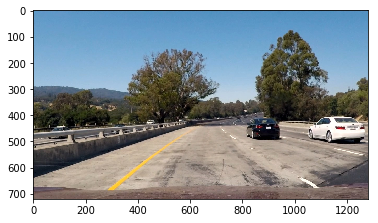

In [6]:
plt.imshow(original_image);

The image contains __two cars__, thus our model should find two bounding boxes with a class prediction for _car_.

Run the model on the input image

In [7]:
out = model.predict(batch)

### Decode predictions, confidences and bounding box coordinates from the prediciton result

In [8]:
def to_bounding_boxes(result, threshold = 0.17):
    grid_size = 7
    num_classes = 20
    num_boxes_per_cell = 2

    predictions = result[:grid_size * grid_size * num_classes]
    assert len(predictions) == 980

    confidences = result[len(predictions) : len(predictions) + grid_size * grid_size * num_boxes_per_cell]
    assert len(confidences) == 98

    coordinates = result[len(predictions) + len(confidences):]
    assert len(coordinates) == 392

    predictions = predictions.reshape([grid_size * grid_size, num_classes])
    confidences = confidences.reshape([grid_size * grid_size, num_boxes_per_cell])
    coordinates = coordinates.reshape([grid_size * grid_size, 2, 4])
    
    boxes = []

    cell_dim = 1. / grid_size

    for cell_i in range(grid_size * grid_size):
        for box_i in range(num_boxes_per_cell):
            grid_row = cell_i // grid_size
            grid_column = cell_i % grid_size

            x, y, width, height = coordinates[cell_i, box_i]

            # We parametrize the bounding box x and y coordinates to be offsets of a particular grid cell location so they are also bounded between 0 and 1
            x = (grid_column * cell_dim) + (x * cell_dim)
            y = (grid_row * cell_dim) + (y * cell_dim)

            # We normalize the bounding box width and height by the image width and height so that they fall between 0 and 1.        
            # This should really be **2, but the original implementation uses **1.8. No idea why though...
            width = width ** 1.8
            height = height ** 1.8

            box_confidence = confidences[cell_i, box_i]

            highest_class_probability_index = np.argmax(predictions[cell_i])
            highest_class_probability = predictions[cell_i, highest_class_probability_index]

            class_confidence = box_confidence * highest_class_probability

            if class_confidence >= threshold:
                boxes.append(np.array([
                    x-(width/2), y-(height/2.), x+(width/2), y+(height/2.),
                    class_confidence, highest_class_probability_index]))
                
    return np.array(boxes)

In [9]:
boxes = to_bounding_boxes(out[0], threshold=0.17) # only keep class predictions with at least 17% confidence

Now we have the bounding boxes and class predictions in a useful format.

__Next up:__ Remove overlapping bounding boxes.

This process is called _Non-Maximum Supression_. A simple and efficient implementation for this can be found here:
http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

In [10]:
def non_maximum_suppression(boxes, threshold, epsilon=0.0001):
    if len(boxes) == 0:
        return []
    
    picks = []
    
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    c = boxes[:, 4]
    
    area = (x2 - x1 + epsilon) * (y2 - y2 + epsilon) 
    idxs = np.argsort(c)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        picks.append(i)
        
        others = idxs[:last]
        xx1 = np.maximum(x1[i], x1[others])
        yy1 = np.maximum(y1[i], y1[others])
        xx2 = np.minimum(x2[i], x2[others])
        yy2 = np.minimum(y2[i], y2[others])

        w = np.maximum(0, xx2 - xx1 + epsilon)
        h = np.maximum(0, yy2 - yy1 + epsilon)
        
        overlap = (w * h) / area[others]
        
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > threshold)[0])))

    return boxes[picks]

Without _Non-Maximum Suppression_ we find 4 bounding boxes:

In [11]:
print(boxes)

[[ 0.66604508  0.56738719  0.75329783  0.67526357  0.2700564   6.        ]
 [ 0.61987298  0.56078983  0.72358966  0.66884433  0.18670541  6.        ]
 [ 0.7389835   0.57076993  0.88162718  0.68145157  0.17469479  6.        ]
 [ 0.82350619  0.53657593  0.98578765  0.72717983  0.42168316  6.        ]]


In [12]:
boxes = non_maximum_suppression(boxes, 0.4) # remove boxes with >= 40% overlap

After removing duplicates we find only two bounding boxes:

In [13]:
print(boxes)

[[ 0.82350619  0.53657593  0.98578765  0.72717983  0.42168316  6.        ]
 [ 0.66604508  0.56738719  0.75329783  0.67526357  0.2700564   6.        ]]


Create an utility method that draws bounding boxes onto an image

In [14]:
import cv2

def mark_objects(boxes, image):
    h, w, _ = image.shape

    for b in boxes:
        x1, y1, x2, y2, confidence, class_index = b
        
        left  = int (x1 * w)
        right = int (x2 * w)
        top   = int (y1 * h)
        bot   = int (y2 * h)

        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        cv2.rectangle(image, (left, top), (right, bot), (255,220,0), thick)

    return image

### Show bounding boxes on resized and original image

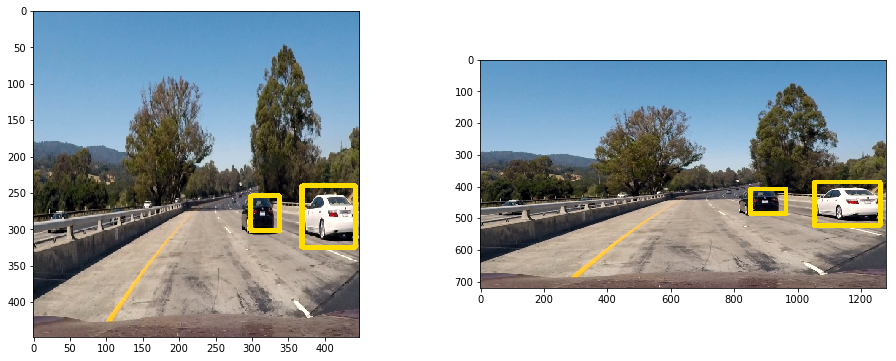

In [15]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(mark_objects(boxes, resized_image))
ax2.imshow(mark_objects(boxes, original_image));

__Awesome!__ Looks like it's working

## Convert weights to tensorflow

To make the model run on android/iOS we'll have to convert the weights from theano to tensorflow format.
The script located at https://github.com/titu1994/Keras-Classification-Models/commit/fb7aed545b447aabd6894b1f319fe4db51ff2ad6 did help me a lot with this process.

In [16]:
from keras import backend as K

K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')
th_model = create_yolov1_tiny_model((3, 448, 448))
th_model.load_weights('yolo-tiny_th.weights')

K.set_image_dim_ordering('tf')
K.set_image_data_format('channels_last')
tf_model = create_yolov1_tiny_model((448, 448, 3))

In [17]:
def shuffle_rows(original_w, nb_last_conv, nb_rows_dense):
    ''' Note :
    This algorithm to shuffle dense layer rows was provided by Kent Sommers (@kentsommer)
    in a gist : https://gist.github.com/kentsommer/e872f65926f1a607b94c2b464a63d0d3
    '''
    converted_w = np.zeros(original_w.shape)
    count = 0
    for index in range(original_w.shape[0]):
        if (index % nb_last_conv) == 0 and index != 0:
            count += 1
        new_index = ((index % nb_last_conv) * nb_rows_dense) + count
        converted_w[index] = original_w[new_index]

    return converted_w

In [18]:
is_first_dense = True
nb_last_conv = 0

for th_layer, tf_layer in zip(th_model.layers, tf_model.layers):
    if th_layer.__class__.__name__ in ['Conv2D']:
        # No change. Conv2D weights always have tensorflow ordering since Keras 2.x
        weights = th_layer.get_weights()
        tf_layer.set_weights(weights)
        
        nb_last_conv = th_layer.filters
    elif th_layer.__class__.__name__ in ['Dense']:
        if is_first_dense:
            is_first_dense = False
            weights = th_layer.get_weights()
            
            nb_rows_dense_layer = weights[0].shape[0] // nb_last_conv
            weights[0] = shuffle_rows(weights[0], nb_last_conv, nb_rows_dense_layer)
            
            tf_layer.set_weights(weights)
        else:
            tf_layer.set_weights(th_layer.get_weights())
            
tf_model.save_weights('yolo-tiny_tf.weights', overwrite=True)

### Check if the model still works

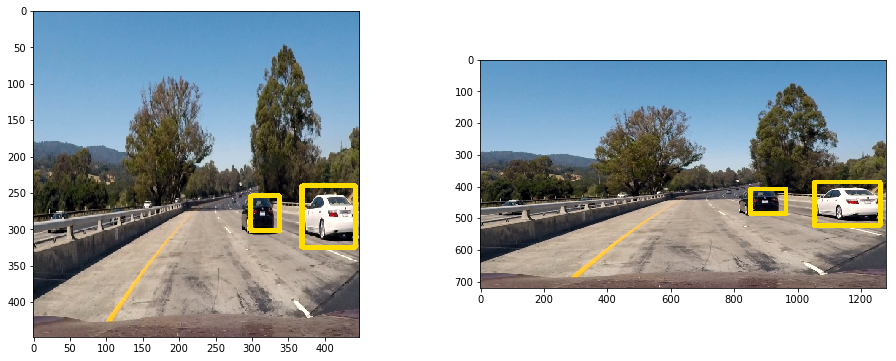

In [19]:
image = load_img(image_path, grayscale=False)
original_image = np.array(image)
resized_image = np.array(image.resize((448, 448)))

batch = np.array(resized_image)
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)

out = tf_model.predict(batch)
boxes = to_bounding_boxes(out[0], threshold=0.17)
boxes = non_maximum_suppression(boxes, 0.4)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(mark_objects(boxes, resized_image))
ax2.imshow(mark_objects(boxes, original_image));

__Alright!__ Looks good :)